# Imports

In [25]:
import cv2
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
import os
from PIL import Image
from scipy.misc import imread
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data handling block

In [26]:
IMG_SIZE = 48
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project"

print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

if GPU == True:
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    facs = [1, 2, 4, 5, 6, 7, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,34,38,39,43,44,45,54,61,62,63,64]


def giveMeFACS():
    counter = 0
    for fac in facs:
        facs_root = glob.glob('%s/Dataset_raw/sorted_FACS_set//%s//*'%(DATA_PATH,fac))
        nb_facs = len(facs_root)
        #if(nb_facs > threshold and nb_facs < threshold_max):
        print("AU number ",fac," has " , nb_facs, " instances")
    
        

def generateDatasetFor(fac): #Define function to get file list, randomly shuffle it and split 80/20
    #Get all corresponding FACS name
    facs_name = []
    cover = 0
    for f in fac:
        facs_files = glob.glob("%s/Dataset_raw/sorted_FACS_set//%s//*" %(DATA_PATH,f))
        for i in facs_files:
            n = os.path.basename(i)
            n_ = n.split('.')[0]
            if n_  in facs_name:
                cover = cover + 1
            if n_  not in facs_name:
                facs_name.append(n_ )
    print("overlap: ",cover)
                               
    #Find cropped pic by name for positive (Remainings are negatives)
    d_neg = {}
    d_pos = {}
    notFacs = glob.glob("%s/notFACS48/*"%(DATA_PATH))
    for i in notFacs:
        n = os.path.basename(i)
        name = n.split('.')[0]
        #0 not corresponding FACS - 1 corresponding FACS
        if(name in facs_name):
            #print(name)
            d_pos[i] = 1
        else:
            d_neg[i] = 0
    
    #print("pos: ",len(d_pos))
    #print("neg: ",len(d_neg))
    #divide dictionary into train and test set 80/20 for each class
    #to have representative number of each class in each set
    d_pos_train = dict(list(d_pos.items())[:int(len(d_pos)*0.8)])
    d_pos_test = dict(list(d_pos.items())[-int(len(d_pos)*0.2):])
    d_neg_train = dict(list(d_neg.items())[:int(len(d_neg)*0.8)])
    d_neg_test = dict(list(d_neg.items())[-int(len(d_neg)*0.2):])
    data_t = {**d_pos_train, **d_neg_train}
    data_p = {**d_pos_test, **d_neg_test}
    
    print("Train +/-: ",len(d_pos_train),"/",len(d_neg_train)," =  ",len(data_t))
    print("Test +/-: ",len(d_pos_test),"/",len(d_neg_test)," =  ",len(data_p))
    print("Total +/-: ",len(d_pos_test)+len(d_pos_train),"/",len(d_neg_test)+len(d_neg_train))
    

    
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)
    keys_p =  list(data_p.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_p)
    
    training_data = []
    training_labels = []
        #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        training_data.append(gray)
        training_labels.append(data_t[k])
    
    prediction_data = []
    prediction_labels = []
            #LOAD data
    for k in keys_p:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        prediction_data.append(gray)
        prediction_labels.append(data_p[k])
    return training_data,training_labels, prediction_data,prediction_labels

giveMeFACS()

class data_loader(torch.utils.data.Dataset):
    def __init__(self, images_input,label_output):
        Images, Y = [], []
        
        for i in range(len(images_input)):
            Images.append(images_input[i])
            Y.append(label_output[i])

        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]      
        img = img.reshape(1, IMG_SIZE, IMG_SIZE) / 255
        
        #Input for Conv2D should be Channels x Height x Width
        img_tensor = transforms.ToTensor()(img).view(1, IMG_SIZE, IMG_SIZE).float()
        label = self.data[index][1]
        return (img_tensor, label)

Data path:  C:/Users/Cerberus/Documents/ML/Project
Image size:  48
GPU enabled:  True
cuda:0
AU number  1  has  177  instances
AU number  2  has  117  instances
AU number  4  has  194  instances
AU number  5  has  102  instances
AU number  6  has  123  instances
AU number  7  has  121  instances
AU number  9  has  75  instances
AU number  10  has  21  instances
AU number  11  has  34  instances
AU number  12  has  131  instances
AU number  13  has  2  instances
AU number  14  has  37  instances
AU number  15  has  94  instances
AU number  16  has  24  instances
AU number  17  has  202  instances
AU number  18  has  9  instances
AU number  19  has  0  instances
AU number  20  has  79  instances
AU number  21  has  3  instances
AU number  22  has  4  instances
AU number  23  has  60  instances
AU number  24  has  58  instances
AU number  25  has  324  instances
AU number  26  has  50  instances
AU number  27  has  81  instances
AU number  28  has  1  instances
AU number  29  has  2  inst

# Stats block

In [27]:
def get_accuracy(model,dataset):
    correct=0
    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
        
        pred=model.forward(test_x)
        y_hat=np.argmax(pred.data)
        if y_hat.item()==test_y.item():
            correct+=1
    return correct/len(dataset)


def get_stats(model,dataset):
    actu_all = []
    pred_all = []

    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
            
        pred=model.forward(test_x)
        y_hat=np.argmax(pred.data)
        
        if GPU == True:
            test_y = test_y.cpu()
            y_hat = y_hat.cpu()
        
        np_actu_y = test_y.data.numpy()[0]
        np_pred_y = y_hat.data.numpy().item()

        actu_all.append(np_actu_y)
        pred_all.append(np_pred_y)

    df_confusion = confusion_matrix(actu_all,pred_all)
    stats = classification_report(actu_all, pred_all)
    return df_confusion,stats

def get_label_quantity(label_set):
    myset = set(label_set)
    labels = np.zeros(len(myset))
    for i in range(len(label_set)):
        labels[label_set[i]] += 1 
    return labels

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# Training definition

In [162]:
def train_AU_Classifier(net,train_set,test_set,criterion,optimizer,epochs,volubile=False,security=False):
    history = []
    sec_limit = 6
    counter_sec = 0
    for epoch in range(1, epochs+1):
        if volubile == True:
            print('Epoch {}/{}'.format(epoch, epochs))
            print('-' * 10)
        
        for step, data in enumerate(train_set, 0):
            train_x, train_y = data
            if GPU == True:
                train_x, train_y = train_x.cuda(), train_y.cuda()
            else:
                train_y = torch.LongTensor(np.array(train_y))
                
            y_hat = net.forward(train_x)
            
            loss = criterion(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if security == True:
            if len(history) > 0:
                if loss.item() == history[-1]:
                    counter_sec += 1
                
        if counter_sec >= sec_limit:
            print('*'*35)
            print("NO TRAINING: ",sec_limit," times the same loss")
            print('*'*35)
            break
            
        history.append(loss.item())
        if volubile == True:  
            epoch_training_acc = get_accuracy(net,train_set)
            print('{} -> Acc: {:.4f}'.format("training",epoch_training_acc))
            epoch_testing_acc = get_accuracy(net,test_set)
            print('{} -> Acc: {:.4f}'.format("testing", epoch_testing_acc))
     
    return net, history

# Happy -> AU 12 + 6

In [149]:
class Model_AU_Happy(torch.nn.Module):
    def __init__(self):
        super(Model_AU_Happy, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 12)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,12)
        self.maxpool2d = nn.MaxPool2d(5,5,2)
        self.fc1 = nn.Linear(10*2*2, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        #print("x ", x.shape)
        x = self.conv1(x)
        #print("conv1 ", x.shape)
        x = self.avgpool2d(x)
        #print("avgpool2d ", x.shape)
        x = self.conv2(x)
        #print("conv2 ", x.shape)
        x = self.maxpool2d(x)
        #print("maxpool2d ", x.shape)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        #result = F.softmax(x, dim=1)
        return result

In [155]:
print("*****************************************************************")
print("Happy")


training_data_AU_Happy,training_labels_AU_Happy,prediction_data_AU_Happy,prediction_labels_AU_Happy = generateDatasetFor([12,6])
train_dataset_AU_Happy = data_loader(training_data_AU_Happy,training_labels_AU_Happy)
train_loader_AU_Happy = torch.utils.data.DataLoader(dataset=train_dataset_AU_Happy, batch_size=1, shuffle=True)
test_dataset_AU_Happy = data_loader(prediction_data_AU_Happy,prediction_labels_AU_Happy)
test_loader_AU_Happy = torch.utils.data.DataLoader(test_dataset_AU_Happy, batch_size=1, shuffle=True)

*****************************************************************
Happy
overlap:  82
Train +/-:  86 / 175  =   261
Test +/-:  21 / 43  =   64
Total +/-:  107 / 218


In [157]:
labels_AU_Happy = ["else","AUs(6+12)"]
epochs_AU_Happy=50
net_AU_Happy = Model_AU_Happy()

if GPU == True:
    net_AU_Happy.cuda()

criterion_AU_Happy = torch.nn.CrossEntropyLoss()
optimizer_AU_Happy = torch.optim.Adam(net_AU_Happy.parameters())
#optimizer_AU_Happy = torch.optim.Adam(net_AU_Happy.parameters(), 0.1, (0.9, 0.999),0.1, 5e-05)
#optimizer_AU_Happy = torch.optim.Adadelta(net_AU_Happy.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer_AU_Happy = torch.optim.Adagrad(net_AU_Happy.parameters(), 1.0, 0, 0.1,0)

classifier_AU_Happy, loss_history_AU_Happy = train_AU_Classifier(net_AU_Happy,train_loader_AU_Happy,test_loader_AU_Happy,
                                                               criterion_AU_Happy,optimizer_AU_Happy,
                                                               epochs_AU_Happy,True,True)

acc_AU_Happy = get_accuracy(classifier_AU_Happy,test_loader_AU_Happy)
confmat_AU_Happy,stats_AU_Happy = get_stats(classifier_AU_Happy,test_loader_AU_Happy)

Epoch 1/50
----------
training -> Acc: 0.6705
testing -> Acc: 0.6719
Epoch 2/50
----------
training -> Acc: 0.8659
testing -> Acc: 0.8281
Epoch 3/50
----------
training -> Acc: 0.8889
testing -> Acc: 0.8438
Epoch 4/50
----------
training -> Acc: 0.8889
testing -> Acc: 0.8438
Epoch 5/50
----------
training -> Acc: 0.9004
testing -> Acc: 0.8438
Epoch 6/50
----------
training -> Acc: 0.8851
testing -> Acc: 0.8125
Epoch 7/50
----------
training -> Acc: 0.8927
testing -> Acc: 0.8281
Epoch 8/50
----------
training -> Acc: 0.9004
testing -> Acc: 0.8750
Epoch 9/50
----------
training -> Acc: 0.9080
testing -> Acc: 0.8594
Epoch 10/50
----------
training -> Acc: 0.8851
testing -> Acc: 0.8125
Epoch 11/50
----------
training -> Acc: 0.9272
testing -> Acc: 0.8594
Epoch 12/50
----------
training -> Acc: 0.8659
testing -> Acc: 0.8281
Epoch 13/50
----------
training -> Acc: 0.9234
testing -> Acc: 0.8594
Epoch 14/50
----------
training -> Acc: 0.9425
testing -> Acc: 0.8594
Epoch 15/50
----------
traini

       t/p         else AUs(6+12) 
         else        39         4 
    AUs(6+12)         9        12 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        43
           1       0.75      0.57      0.65        21

   micro avg       0.80      0.80      0.80        64
   macro avg       0.78      0.74      0.75        64
weighted avg       0.79      0.80      0.79        64

Accuracy (48x48) : 0.80


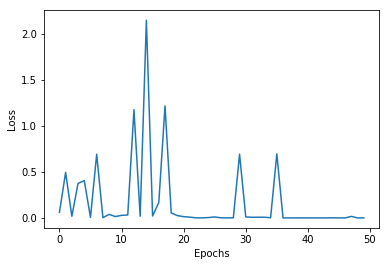

In [158]:
print_cm(confmat_AU_Happy,labels_AU_Happy)
print("-----------------------------------------------")
print(stats_AU_Happy)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Happy))
plt.plot(np.array(range(len(loss_history_AU_Happy))), loss_history_AU_Happy)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Disgust -> AU 9 + 15 + 16

In [159]:
class Model_AU_Disgust(torch.nn.Module):

    def __init__(self):
        super(Model_AU_Disgust, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,6)
        self.maxpool2d = nn.MaxPool2d(10,10,4)
        self.fc1 = nn.Linear(10*2*2, 12)
        self.fc2 = nn.Linear(12, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool2d(x)
        x = self.conv2(x)
        x = self.maxpool2d(x)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        return result

In [160]:
print("*****************************************************************")
print("Disgust")
#dataset for AU 9 and 10 -> Disgust
training_data_AU_Disgust,training_labels_AU_Disgust,prediction_data_AU_Disgust,prediction_labels_AU_Disgust = generateDatasetFor([9,15,16])
train_dataset_AU_Disgust = data_loader(training_data_AU_Disgust,training_labels_AU_Disgust)
train_loader_AU_Disgust = torch.utils.data.DataLoader(dataset=train_dataset_AU_Disgust, batch_size=1, shuffle=True)
test_dataset_AU_Disgust = data_loader(prediction_data_AU_Disgust,prediction_labels_AU_Disgust)
test_loader_AU_Disgust = torch.utils.data.DataLoader(test_dataset_AU_Disgust, batch_size=1, shuffle=True)

*****************************************************************
Disgust
overlap:  5
Train +/-:  82 / 179  =   261
Test +/-:  20 / 44  =   64
Total +/-:  102 / 223


In [161]:
labels_AU_Disgust = ["else","AUs(9+15+16)"]
epochs_AU_Disgust=50


net_AU_Disgust = Model_AU_Disgust()

if GPU == True:
    net_AU_Disgust.cuda()

criterion_AU_Disgust = torch.nn.CrossEntropyLoss()
optimizer_AU_Disgust = torch.optim.Adam(net_AU_Disgust.parameters())
#optimizer_AU_Disgust = torch.optim.Adam(net_AU_Disgust.parameters(), 0.001, (0.9, 0.999), 0.1, 5e-05)

classifier_AU_Disgust, loss_history_AU_Disgust = train_AU_Classifier(net_AU_Disgust,train_loader_AU_Disgust,test_loader_AU_Disgust,
                                                               criterion_AU_Disgust,optimizer_AU_Disgust,
                                                               epochs_AU_Disgust,True,True)

acc_AU_Disgust = get_accuracy(classifier_AU_Disgust,test_loader_AU_Disgust)
confmat_AU_Disgust,stats_AU_Disgust = get_stats(classifier_AU_Disgust,test_loader_AU_Disgust)

Epoch 1/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 2/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 3/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 4/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 5/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 6/50
----------
training -> Acc: 0.6858
testing -> Acc: 0.6875
Epoch 7/50
----------
training -> Acc: 0.7165
testing -> Acc: 0.6875
Epoch 8/50
----------
training -> Acc: 0.6897
testing -> Acc: 0.6875
Epoch 9/50
----------
training -> Acc: 0.7050
testing -> Acc: 0.7031
Epoch 10/50
----------
training -> Acc: 0.8084
testing -> Acc: 0.7031
Epoch 11/50
----------
training -> Acc: 0.7701
testing -> Acc: 0.6719
Epoch 12/50
----------
training -> Acc: 0.7203
testing -> Acc: 0.6094
Epoch 13/50
----------
training -> Acc: 0.8046
testing -> Acc: 0.7031
Epoch 14/50
----------
training -> Acc: 0.7395
testing -> Acc: 0.7031
Epoch 15/50
----------
traini

         t/p             else AUs(9+15+16) 
            else           41            3 
    AUs(9+15+16)           12            8 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.93      0.85        44
           1       0.73      0.40      0.52        20

   micro avg       0.77      0.77      0.77        64
   macro avg       0.75      0.67      0.68        64
weighted avg       0.76      0.77      0.74        64

Accuracy (48x48) : 0.77


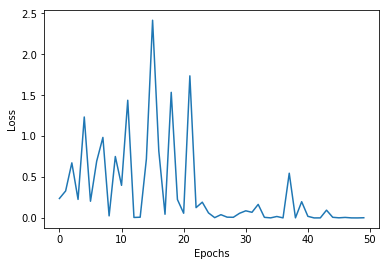

In [262]:
print_cm(confmat_AU_Disgust,labels_AU_Disgust)
print("-----------------------------------------------")
print(stats_AU_Disgust)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Disgust))
plt.plot(np.array(range(len(loss_history_AU_Disgust))), loss_history_AU_Disgust)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Contempt -> AU 14

In [164]:
class Model_AU_Contempt(torch.nn.Module):

    def __init__(self):
        super(Model_AU_Contempt, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,6)
        self.maxpool2d = nn.MaxPool2d(10,10,4)
        self.fc1 = nn.Linear(10*2*2, 12)
        self.fc2 = nn.Linear(12, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool2d(x)
        x = self.conv2(x)
        x = self.maxpool2d(x)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        return result

In [165]:
print("*****************************************************************")
print("Contempt")

training_data_AU_Contempt,training_labels_AU_Contempt,prediction_data_AU_Contempt,prediction_labels_AU_Contempt = generateDatasetFor([14])
train_dataset_AU_Contempt = data_loader(training_data_AU_Contempt,training_labels_AU_Contempt)
train_loader_AU_Contempt = torch.utils.data.DataLoader(dataset=train_dataset_AU_Contempt, batch_size=1, shuffle=True)
test_dataset_AU_Contempt = data_loader(prediction_data_AU_Contempt,prediction_labels_AU_Contempt)
test_loader_AU_Contempt = torch.utils.data.DataLoader(test_dataset_AU_Contempt, batch_size=1, shuffle=True)

*****************************************************************
Contempt
overlap:  0
Train +/-:  25 / 236  =   261
Test +/-:  6 / 59  =   65
Total +/-:  31 / 295


In [166]:
labels_AU_Contempt = ["else","AUs(14)"]
epochs_AU_Contempt=50


net_AU_Contempt = Model_AU_Contempt()

if GPU == True:
    net_AU_Contempt.cuda()

criterion_AU_Contempt = torch.nn.CrossEntropyLoss()
optimizer_AU_Contempt = torch.optim.Adam(net_AU_Contempt.parameters())
#optimizer_AU_Contempt = torch.optim.Adam(net_AU_Contempt.parameters(), 0.001, (0.9, 0.999), 0.1, 5e-05)

classifier_AU_Contempt, loss_history_AU_Contempt = train_AU_Classifier(net_AU_Contempt,train_loader_AU_Contempt,test_loader_AU_Contempt,
                                                               criterion_AU_Contempt,optimizer_AU_Contempt,
                                                               epochs_AU_Contempt,True,True)

acc_AU_Contempt = get_accuracy(classifier_AU_Contempt,test_loader_AU_Contempt)
confmat_AU_Contempt,stats_AU_Contempt = get_stats(classifier_AU_Contempt,test_loader_AU_Contempt)

Epoch 1/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 2/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 3/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 4/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 5/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 6/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 7/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 8/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 9/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 10/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 11/50
----------
training -> Acc: 0.9042
testing -> Acc: 0.9077
Epoch 12/50
----------
training -> Acc: 0.9157
testing -> Acc: 0.9077
Epoch 13/50
----------
training -> Acc: 0.9080
testing -> Acc: 0.9077
Epoch 14/50
----------
training -> Acc: 0.9080
testing -> Acc: 0.9077
Epoch 15/50
----------
traini

      t/p      else AUs(14) 
       else      55       4 
    AUs(14)       3       3 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        59
           1       0.43      0.50      0.46         6

   micro avg       0.89      0.89      0.89        65
   macro avg       0.69      0.72      0.70        65
weighted avg       0.90      0.89      0.90        65

Accuracy (48x48) : 0.89


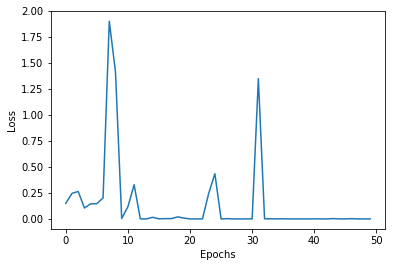

In [261]:
print_cm(confmat_AU_Contempt,labels_AU_Contempt)
print("-----------------------------------------------")
print(stats_AU_Contempt)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Contempt))
plt.plot(np.array(range(len(loss_history_AU_Contempt))), loss_history_AU_Contempt)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Angry -> AU 4 + 5 + 7 + 23

In [251]:
class Model_AU_Angry(torch.nn.Module):

    def __init__(self):
        super(Model_AU_Angry, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,6)
        self.maxpool2d = nn.MaxPool2d(10,10,4)
        self.fc1 = nn.Linear(10*2*2, 12)
        self.fc2 = nn.Linear(12, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool2d(x)
        x = self.conv2(x)
        x = self.maxpool2d(x)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        return result

In [252]:
print("*****************************************************************")
print("Angry")

training_data_AU_Angry,training_labels_AU_Angry,prediction_data_AU_Angry,prediction_labels_AU_Angry = generateDatasetFor([4,5,7,23])
train_dataset_AU_Angry = data_loader(training_data_AU_Angry,training_labels_AU_Angry)
train_loader_AU_Angry = torch.utils.data.DataLoader(dataset=train_dataset_AU_Angry, batch_size=1, shuffle=True)
test_dataset_AU_Angry = data_loader(prediction_data_AU_Angry,prediction_labels_AU_Angry)
test_loader_AU_Angry = torch.utils.data.DataLoader(test_dataset_AU_Angry, batch_size=1, shuffle=True)

*****************************************************************
Angry
overlap:  176
Train +/-:  170 / 91  =   261
Test +/-:  42 / 22  =   64
Total +/-:  212 / 113


In [253]:
labels_AU_Angry = ["else","AUs(4 + 5 + 7 + 23)"]
epochs_AU_Angry=50


net_AU_Angry = Model_AU_Angry()

if GPU == True:
    net_AU_Angry.cuda()

criterion_AU_Angry = torch.nn.CrossEntropyLoss()
#optimizer_AU_Angry = torch.optim.Adam(net_AU_Angry.parameters())
#optimizer_AU_Angry = torch.optim.Adam(net_AU_Angry.parameters(), 0.1, (0.9, 0.999), 0.1, 5e-05)
optimizer_AU_Angry = torch.optim.Adadelta(net_AU_Angry.parameters(), 0.01, 0.9, 1e-06, 5e-05)

classifier_AU_Angry, loss_history_AU_Angry = train_AU_Classifier(net_AU_Angry,train_loader_AU_Angry,test_loader_AU_Angry,
                                                               criterion_AU_Angry,optimizer_AU_Angry,
                                                               epochs_AU_Angry,True,True)

acc_AU_Angry = get_accuracy(classifier_AU_Angry,test_loader_AU_Angry)
confmat_AU_Angry,stats_AU_Angry = get_stats(classifier_AU_Angry,test_loader_AU_Angry)

Epoch 1/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 2/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 3/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 4/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 5/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 6/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 7/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 8/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 9/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 10/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 11/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 12/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 13/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 14/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.6562
Epoch 15/50
----------
traini

            t/p                        else AUs(4 + 5 + 7 + 23) 
                   else                   2                  20 
    AUs(4 + 5 + 7 + 23)                   3                  39 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.09      0.15        22
           1       0.66      0.93      0.77        42

   micro avg       0.64      0.64      0.64        64
   macro avg       0.53      0.51      0.46        64
weighted avg       0.57      0.64      0.56        64

Accuracy (48x48) : 0.64


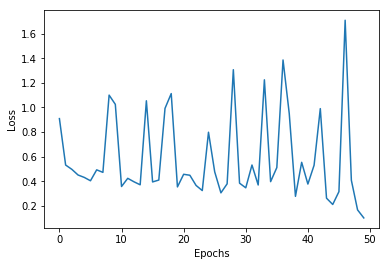

In [260]:
print_cm(confmat_AU_Angry,labels_AU_Angry)
print("-----------------------------------------------")
print(stats_AU_Angry)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Angry))
plt.plot(np.array(range(len(loss_history_AU_Angry))), loss_history_AU_Angry)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Fear -> AU 1 + 2 + 4 + 5 + 7 + 20 + 26

In [244]:
class Model_AU_Fear(torch.nn.Module):

    def __init__(self):
        super(Model_AU_Fear, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 15)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,6)
        self.maxpool2d = nn.MaxPool2d(10,10,4)
        self.fc1 = nn.Linear(10*2*2, 12)
        self.fc2 = nn.Linear(12, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool2d(x)
        x = self.conv2(x)
        x = self.maxpool2d(x)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        return result

In [245]:
print("*****************************************************************")
print("Fear")

training_data_AU_Fear,training_labels_AU_Fear,prediction_data_AU_Fear,prediction_labels_AU_Fear = generateDatasetFor([5,7,20,26])
train_dataset_AU_Fear = data_loader(training_data_AU_Fear,training_labels_AU_Fear)
train_loader_AU_Fear = torch.utils.data.DataLoader(dataset=train_dataset_AU_Fear, batch_size=1, shuffle=True)
test_dataset_AU_Fear = data_loader(prediction_data_AU_Fear,prediction_labels_AU_Fear)
test_loader_AU_Fear = torch.utils.data.DataLoader(test_dataset_AU_Fear, batch_size=1, shuffle=True)

*****************************************************************
Fear
overlap:  67
Train +/-:  144 / 117  =   261
Test +/-:  36 / 29  =   65
Total +/-:  180 / 146


In [249]:
labels_AU_Fear = ["else","AUs(1 + 2 + 4 + 5 + 7 + 20 + 26)"]
epochs_AU_Fear=50

net_AU_Fear = Model_AU_Fear()

if GPU == True:
    net_AU_Fear.cuda()

criterion_AU_Fear = torch.nn.CrossEntropyLoss()
#optimizer_AU_Fear = torch.optim.Adam(net_AU_Fear.parameters())
optimizer_AU_Fear = torch.optim.Adam(net_AU_Fear.parameters(), 0.01, (0.9, 0.999), 1.0, 5e-05)

classifier_AU_Fear, loss_history_AU_Fear = train_AU_Classifier(net_AU_Fear,train_loader_AU_Fear,test_loader_AU_Fear,
                                                               criterion_AU_Fear,optimizer_AU_Fear,
                                                               epochs_AU_Fear,True,True)

acc_AU_Fear = get_accuracy(classifier_AU_Fear,test_loader_AU_Fear)
confmat_AU_Fear,stats_AU_Fear = get_stats(classifier_AU_Fear,test_loader_AU_Fear)

Epoch 1/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 2/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 3/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 4/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 5/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 6/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 7/50
----------
training -> Acc: 0.5517
testing -> Acc: 0.5538
Epoch 8/50
----------
training -> Acc: 0.5862
testing -> Acc: 0.5538
Epoch 9/50
----------
training -> Acc: 0.7011
testing -> Acc: 0.5231
Epoch 10/50
----------
training -> Acc: 0.7011
testing -> Acc: 0.5231
Epoch 11/50
----------
training -> Acc: 0.7050
testing -> Acc: 0.4923
Epoch 12/50
----------
training -> Acc: 0.7088
testing -> Acc: 0.4923
Epoch 13/50
----------
training -> Acc: 0.6513
testing -> Acc: 0.5538
Epoch 14/50
----------
training -> Acc: 0.7241
testing -> Acc: 0.4923
Epoch 15/50
----------
traini

                   t/p                                           else AUs(1 + 2 + 4 + 5 + 7 + 20 + 26) 
                                else                                7                               22 
    AUs(1 + 2 + 4 + 5 + 7 + 20 + 26)                                8                               28 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.24      0.32        29
           1       0.56      0.78      0.65        36

   micro avg       0.54      0.54      0.54        65
   macro avg       0.51      0.51      0.48        65
weighted avg       0.52      0.54      0.50        65

Accuracy (48x48) : 0.54


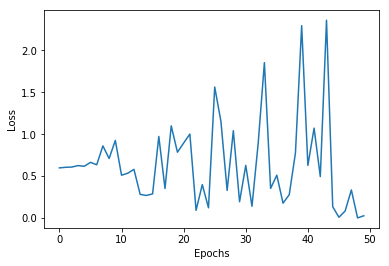

In [259]:
print_cm(confmat_AU_Fear,labels_AU_Fear)
print("-----------------------------------------------")
print(stats_AU_Fear)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Fear))
plt.plot(np.array(range(len(loss_history_AU_Fear))), loss_history_AU_Fear)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Sadness -> AU 1 + 4 + 15

In [255]:
print("*****************************************************************")
print("Sadnesss")

training_data_AU_Sadness,training_labels_AU_Sadness,prediction_data_AU_Sadness,prediction_labels_AU_Sadness = generateDatasetFor([1,4,15])
train_dataset_AU_Sadness = data_loader(training_data_AU_Sadness,training_labels_AU_Sadness)
train_loader_AU_Sadness = torch.utils.data.DataLoader(dataset=train_dataset_AU_Sadness, batch_size=1, shuffle=True)
test_dataset_AU_Sadness = data_loader(prediction_data_AU_Sadness,prediction_labels_AU_Sadness)
test_loader_AU_Sadness = torch.utils.data.DataLoader(test_dataset_AU_Sadness, batch_size=1, shuffle=True)

*****************************************************************
Sadnesss
overlap:  120
Train +/-:  172 / 88  =   260
Test +/-:  43 / 22  =   65
Total +/-:  215 / 110


In [256]:
class Model_AU_Sadness(torch.nn.Module):
    def __init__(self):
        super(Model_AU_Sadness, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(20,10,12)
        self.maxpool2d = nn.MaxPool2d(10,10,5)
        self.fc1 = nn.Linear(10*2*2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        #print("x ", x.shape)
        x = self.conv1(x)
        #print("conv1 ", x.shape)
        x = self.avgpool2d(x)
        #print("avgpool2d ", x.shape)
        x = self.conv2(x)
        #print("conv2 ", x.shape)
        x = self.maxpool2d(x)
        #print("maxpool2d ", x.shape)
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        result = F.relu(self.fc2(x))
        #result = F.softmax(x, dim=1)
        return result

In [257]:
labels_AU_Sadness = ["else","AUs(1 + 4 + 15)"]
epochs_AU_Sadness=50

net_AU_Sadness = Model_AU_Sadness()

if GPU == True:
    net_AU_Sadness.cuda()

criterion_AU_Sadness = torch.nn.CrossEntropyLoss()
#optimizer_AU_Sadness = torch.optim.Adam(net_AU_Sadness.parameters())
#optimizer_AU_Sadness = torch.optim.Adam(net_AU_Sadness.parameters(), 0.01, (0.9, 0.999), 0.1, 5e-05)
optimizer_AU_Sadness = torch.optim.Adadelta(net_AU_Sadness.parameters(), 0.01, 0.9, 1e-06, 5e-05)

classifier_AU_Sadness, loss_history_AU_Sadness = train_AU_Classifier(net_AU_Sadness,train_loader_AU_Sadness,test_loader_AU_Sadness,
                                                               criterion_AU_Sadness,optimizer_AU_Sadness,
                                                               epochs_AU_Sadness,True,True)

acc_AU_Sadness = get_accuracy(classifier_AU_Sadness,test_loader_AU_Sadness)
confmat_AU_Sadness,stats_AU_Sadness = get_stats(classifier_AU_Sadness,test_loader_AU_Sadness)

Epoch 1/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 2/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 3/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 4/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 5/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 6/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 7/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 8/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 9/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 10/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 11/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 12/50
----------
training -> Acc: 0.6615
testing -> Acc: 0.6615
Epoch 13/50
----------
training -> Acc: 0.6731
testing -> Acc: 0.6615
Epoch 14/50
----------
training -> Acc: 0.6808
testing -> Acc: 0.6615
Epoch 15/50
----------
traini

          t/p                  else AUs(1 + 4 + 15) 
               else               4              18 
    AUs(1 + 4 + 15)               3              40 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.18      0.28        22
           1       0.69      0.93      0.79        43

   micro avg       0.68      0.68      0.68        65
   macro avg       0.63      0.56      0.53        65
weighted avg       0.65      0.68      0.62        65

Accuracy (48x48) : 0.68


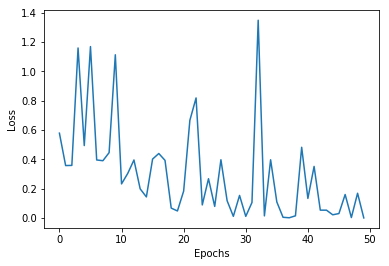

In [258]:
print_cm(confmat_AU_Sadness,labels_AU_Sadness)
print("-----------------------------------------------")
print(stats_AU_Sadness)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Sadness))
plt.plot(np.array(range(len(loss_history_AU_Sadness))), loss_history_AU_Sadness)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Surprise -> 1 + 2 + 5 + 26

In [227]:
print("*****************************************************************")
print("Surprise")

training_data_AU_Surprise,training_labels_AU_Surprise,prediction_data_AU_Surprise,prediction_labels_AU_Surprise = generateDatasetFor([1,2,5,26])
train_dataset_AU_Surprise = data_loader(training_data_AU_Surprise,training_labels_AU_Surprise)
train_loader_AU_Surprise = torch.utils.data.DataLoader(dataset=train_dataset_AU_Surprise, batch_size=1, shuffle=True)
test_dataset_AU_Surprise = data_loader(prediction_data_AU_Surprise,prediction_labels_AU_Surprise)
test_loader_AU_Surprise = torch.utils.data.DataLoader(test_dataset_AU_Surprise, batch_size=1, shuffle=True)

*****************************************************************
Surprise
overlap:  221
Train +/-:  115 / 146  =   261
Test +/-:  28 / 36  =   64
Total +/-:  143 / 182


In [228]:
class Model_AU_Surprise(torch.nn.Module):
    def __init__(self):
        super(Model_AU_Surprise, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 12)
        self.avgpool2d = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(10,10,12)
        self.maxpool2d = nn.MaxPool2d(5,5,2)
        self.fc1 = nn.Linear(10*2*2, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        #print("x ", x.shape)
        #print(x)
        x = self.conv1(x)
        #print("conv1 ", x.shape)
        x = self.avgpool2d(x)
        #print("avgpool2d ", x.shape)
        x = self.conv2(x)
        #print("conv2 ", x.shape)
        x = self.maxpool2d(x)
        #print("maxpool2d ", x.shape)
        x = x.view(-1, 10*2*2)
        x = torch.relu(self.fc1(x))
        result = torch.relu(self.fc2(x))
        #result = F.softmax(x, dim=1)
        return result

In [231]:
labels_AU_Surprise = ["else","AUs(1 + 2 + 5 + 26)"]
epochs_AU_Surprise=50

net_AU_Surprise = Model_AU_Surprise()

if GPU == True:
    net_AU_Surprise.cuda()

criterion_AU_Surprise = torch.nn.CrossEntropyLoss()
#optimizer_AU_Surprise = torch.optim.Adam(net_AU_Surprise.parameters())
optimizer_AU_Surprise = torch.optim.Adam(net_AU_Surprise.parameters(), 0.001, (0.9, 0.999), 1, 5e-05)

classifier_AU_Surprise, loss_history_AU_Surprise = train_AU_Classifier(net_AU_Surprise,train_loader_AU_Surprise,test_loader_AU_Surprise,
                                                               criterion_AU_Surprise,optimizer_AU_Surprise,
                                                               epochs_AU_Surprise,True,True)

acc_AU_Surprise = get_accuracy(classifier_AU_Surprise,test_loader_AU_Surprise)
confmat_AU_Surprise,stats_AU_Surprise = get_stats(classifier_AU_Surprise,test_loader_AU_Surprise)

Epoch 1/50
----------
training -> Acc: 0.5670
testing -> Acc: 0.5625
Epoch 2/50
----------
training -> Acc: 0.5594
testing -> Acc: 0.5625
Epoch 3/50
----------
training -> Acc: 0.5594
testing -> Acc: 0.5625
Epoch 4/50
----------
training -> Acc: 0.5594
testing -> Acc: 0.5625
Epoch 5/50
----------
training -> Acc: 0.5594
testing -> Acc: 0.5625
Epoch 6/50
----------
training -> Acc: 0.5632
testing -> Acc: 0.5781
Epoch 7/50
----------
training -> Acc: 0.8467
testing -> Acc: 0.6875
Epoch 8/50
----------
training -> Acc: 0.8621
testing -> Acc: 0.6250
Epoch 9/50
----------
training -> Acc: 0.8467
testing -> Acc: 0.6250
Epoch 10/50
----------
training -> Acc: 0.8238
testing -> Acc: 0.6562
Epoch 11/50
----------
training -> Acc: 0.7931
testing -> Acc: 0.5938
Epoch 12/50
----------
training -> Acc: 0.8697
testing -> Acc: 0.6719
Epoch 13/50
----------
training -> Acc: 0.8621
testing -> Acc: 0.6406
Epoch 14/50
----------
training -> Acc: 0.8582
testing -> Acc: 0.6250
Epoch 15/50
----------
traini

            t/p                        else AUs(1 + 2 + 5 + 26) 
                   else                  21                  15 
    AUs(1 + 2 + 5 + 26)                  11                  17 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.58      0.62        36
           1       0.53      0.61      0.57        28

   micro avg       0.59      0.59      0.59        64
   macro avg       0.59      0.60      0.59        64
weighted avg       0.60      0.59      0.60        64

Accuracy (48x48) : 0.59


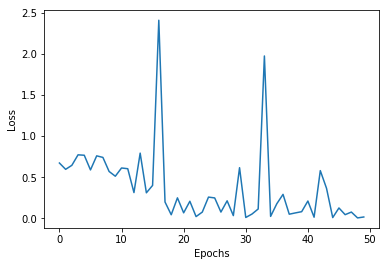

In [232]:
print_cm(confmat_AU_Surprise,labels_AU_Surprise)
print("-----------------------------------------------")
print(stats_AU_Surprise)
print("Accuracy (48x48) : %0.2f" % (acc_AU_Surprise))
plt.plot(np.array(range(len(loss_history_AU_Surprise))), loss_history_AU_Surprise)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# ===================================================

# AUs - 2 - EMO

# ===================================================

# Data handling block

In [263]:
print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

#GET EMOTION DATASET
emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list
#emotions = ["fear", "happy","surprise"] #Emotion list

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("%s/dataset48//%s//*" %(DATA_PATH,emotion))
    random.shuffle(files)
    training = files[:int(len(files)*0.6)] #get first 80% of file list
    prediction = files[-int(len(files)*0.4):] #get last 20% of file list
    return training, prediction

def make_sets():
    td = []
    tl = []
    pd = []
    pl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pd.append(item)
            pl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]
    
    data_p= {}
    for i in range(len(pd)):
        data_p[pd[i]] = pl[i]
        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)
    keys_p =  list(data_p.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_p)

    training_data = []
    training_labels = []
        #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        training_data.append(gray)
        training_labels.append(data_t[k])
    
    prediction_data = []
    prediction_labels = []
            #LOAD data
    for k in keys_p:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        prediction_data.append(gray)
        prediction_labels.append(data_p[k])
    return training_data, training_labels, prediction_data, prediction_labels

class data_loader_vec(torch.utils.data.Dataset):
    def __init__(self, vec_input,label_output):
        Vec, Y = [], []
        
        for i in range(len(vec_input)):
            Vec.append(vec_input[i])
            Y.append(label_output[i])

        data = [(x, y) for x, y in zip(Vec, Y)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        vec = self.data[index][0]
        vec_tensor = torch.Tensor(vec)
        label = self.data[index][1]
        return (vec_tensor, label)

Data path:  C:/Users/Cerberus/Documents/ML/Project
Image size:  48
GPU enabled:  True


# Training definition

In [264]:
def train_AU2EMO_Classifier(net,train_set,test_set,criterion,optimizer,epochs,volubile=False,security=False):
    history = []
    sec_limit = 3
    counter_sec = 0
    for epoch in range(1, epochs+1):
        if volubile == True:
            print('Epoch {}/{}'.format(epoch, epochs))
            print('-' * 10)
        
        for step, data in enumerate(train_set, 0):
            train_x, train_y = data
            if GPU == True:
                train_x, train_y = train_x.cuda(), train_y.cuda()
            else:
                train_y = torch.LongTensor(np.array(train_y))
                
            y_hat = net.forward(train_x)
            
            loss = criterion(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if security == True:
            if len(history) > 0:
                if loss.item() == history[-1]:
                    counter_sec += 1
                
        if counter_sec >= sec_limit:
            print('*'*35)
            print("NO TRAINING: ",sec_limit," times the same loss")
            print('*'*35)
            break
            
        history.append(loss.item())
        if volubile == True:  
            epoch_training_acc = get_accuracy(net,train_set)
            print('{} -> Acc: {:.4f}'.format("training",epoch_training_acc))
            epoch_testing_acc = get_accuracy(net,test_set)
            print('{} -> Acc: {:.4f}'.format("testing", epoch_testing_acc))
     
    return net, history         

# Select AUs CNN to input to model

In [265]:
AUmodels=[]
AUmodels.append(classifier_AU_Happy)
AUmodels.append(classifier_AU_Contempt)
AUmodels.append(classifier_AU_Angry)
AUmodels.append(classifier_AU_Fear)
AUmodels.append(classifier_AU_Sadness)
AUmodels.append(classifier_AU_Surprise)
AUmodels.append(classifier_AU_Disgust)



# Generate AUs CNN Output dataset

In [266]:
#Get AU_Classifier output on training set
#give list of model
#return vectors with output values of each
def getAUClassification(model,img_input):
    vec = []
    for m in model:
        y_hat = m.forward(img_input)
        if GPU == True:
            y_hat = y_hat.cpu()
        vec.append(y_hat.detach().numpy())
        #Manip on vector -> Should put that in AU Classif
    vec= [y for x in vec for y in x]
    vec= [y for x in vec for y in x]
    return vec

#Create dataset with corresponding vectors
training_data, training_labels, prediction_data, prediction_labels = make_sets()
train_dataset_img = data_loader(training_data,training_labels)
train_loader_img = torch.utils.data.DataLoader(dataset=train_dataset_img, batch_size=1, shuffle=True)
test_dataset_img = data_loader(prediction_data,prediction_labels)
test_loader_img = torch.utils.data.DataLoader(test_dataset_img, batch_size=1, shuffle=True)

training_data_vec = []
training_label_vec = []
for step, data in enumerate(train_loader_img, 0):
        train_x, train_y = data
        if GPU == True:
            train_x = train_x.cuda()
        x_vec = getAUClassification(AUmodels,train_x)
        training_data_vec.append(x_vec)
        training_label_vec.append(train_y.detach().numpy().item())

prediction_data_vec = []
prediction_label_vec = []
for step, data in enumerate(test_loader_img, 0):
        train_x, train_y = data
        if GPU == True:
            train_x= train_x.cuda()
        x_vec = getAUClassification(AUmodels,train_x)
        prediction_data_vec.append(x_vec)          
        prediction_label_vec.append(train_y.detach().numpy().item())

train_dataset = data_loader_vec(training_data_vec,training_label_vec)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_dataset = data_loader_vec(prediction_data_vec,prediction_label_vec)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


print("train set:",len(train_loader))
print("test set:",len(test_loader))
print(prediction_label_vec)

train set: 193
test set: 129
[0, 4, 4, 0, 2, 5, 4, 6, 4, 6, 2, 0, 3, 6, 3, 6, 6, 6, 2, 5, 4, 6, 0, 6, 0, 2, 0, 6, 0, 2, 2, 5, 6, 4, 2, 6, 0, 2, 4, 1, 6, 5, 4, 2, 0, 0, 4, 5, 4, 6, 2, 5, 4, 6, 4, 1, 0, 4, 2, 5, 1, 2, 2, 1, 4, 0, 6, 2, 4, 0, 4, 3, 4, 1, 6, 2, 2, 1, 6, 2, 3, 4, 6, 6, 6, 4, 6, 5, 4, 4, 4, 6, 4, 6, 6, 6, 3, 2, 0, 2, 0, 6, 5, 6, 4, 5, 3, 4, 3, 2, 2, 6, 6, 3, 6, 2, 0, 0, 6, 4, 1, 4, 0, 3, 2, 6, 6, 3, 5]


In [267]:
class Model_AU2EMO(nn.Module):
    def __init__(self):
        super(Model_AU2EMO, self).__init__()
        self.fc1 = nn.Linear(len(AUmodels)*2,20)
        self.fc2 = nn.Linear(20,10)
        self.fc3 = nn.Linear(10,len(emotions))
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [269]:
losses = []
accs = []
epochs_AU2EMO=100

net_AU2EMO = Model_AU2EMO()

if GPU == True:
    net_AU2EMO.cuda()


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(net_AU2EMO.parameters(), 0.1, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(net_AU2EMO.parameters(), lr=1e-4, momentum=0.9)

classifier_AU2EMO, loss_history_AU2EMO = train_AU2EMO_Classifier(net_AU2EMO,train_loader,test_loader,
                                                               criterion,optimizer,
                                                               epochs_AU2EMO,True)

acc_AU2EMO = get_accuracy(classifier_AU2EMO,test_loader)
confmat_AU2EMO,stats_AU2EMO = get_stats(classifier_AU2EMO,test_loader)

Epoch 1/100
----------
training -> Acc: 0.1192
testing -> Acc: 0.1085
Epoch 2/100
----------
training -> Acc: 0.3057
testing -> Acc: 0.3256
Epoch 3/100
----------
training -> Acc: 0.2953
testing -> Acc: 0.3411
Epoch 4/100
----------
training -> Acc: 0.2902
testing -> Acc: 0.3023
Epoch 5/100
----------
training -> Acc: 0.2953
testing -> Acc: 0.3023
Epoch 6/100
----------
training -> Acc: 0.2902
testing -> Acc: 0.3101
Epoch 7/100
----------
training -> Acc: 0.2902
testing -> Acc: 0.3101
Epoch 8/100
----------
training -> Acc: 0.2902
testing -> Acc: 0.3411
Epoch 9/100
----------
training -> Acc: 0.2902
testing -> Acc: 0.3488
Epoch 10/100
----------
training -> Acc: 0.3212
testing -> Acc: 0.3643
Epoch 11/100
----------
training -> Acc: 0.3161
testing -> Acc: 0.3488
Epoch 12/100
----------
training -> Acc: 0.3264
testing -> Acc: 0.3643
Epoch 13/100
----------
training -> Acc: 0.3420
testing -> Acc: 0.3643
Epoch 14/100
----------
training -> Acc: 0.3523
testing -> Acc: 0.3566
Epoch 15/100
--

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger       12        1        1        0        0        1        3 
    contempt        1        6        0        0        0        0        0 
     disgust        1        0       21        0        0        1        0 
        fear        2        1        1        3        0        2        1 
       happy        0        0        1        0       26        0        0 
     sadness        1        0        1        1        0        8        0 
    surprise        0        0        0        0        0        0       33 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.75      0.86      0.80         7
           2       0.84      0.91      0.87        23
           3       0.75      0.30      0.43        10
           4       1.00      0.96      0.98        27
           

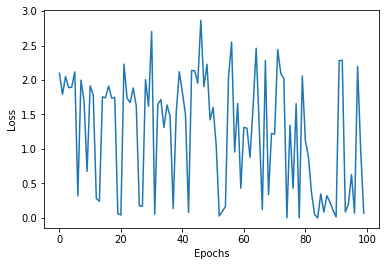

In [270]:
print_cm(confmat_AU2EMO,emotions)
print("-----------------------------------------------")
print(stats_AU2EMO)
print("Accuracy (48x48) : %0.2f" % (acc_AU2EMO))
plt.plot(np.array(range(len(loss_history_AU2EMO))), loss_history_AU2EMO)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Cross validation

In [271]:
def make_one_set_vec():
    td = []
    tl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            td.append(item)
            tl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]

        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)

    training_data = []
    training_labels = []
    #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        training_data.append(gray)
        training_labels.append(data_t[k])
    

    return training_data, training_labels



def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def chunks(l, n):
    """Return n-sized chunks from l."""
    chunks = list(get_chunks(l, n))

    #print(chunks)    
    if(len(chunks[-1]) < n):
        chunks[-2] = chunks[-2] + chunks[-1]
        del chunks[-1]

    return chunks

def get_separated_sets(sets,index):
    big_one = []
    small_one = []
    for i in range(len(sets)):
        if(i == index):
            small_one = sets[i]
        else:
            big_one = big_one + sets[i]
            
    return big_one,small_one

In [272]:
def cross_validation_score(data,labels,epochs,cv=5):
    chunk_size = int(len(set_data_cv)/cv)
    #divide the sets by cv
    data_sets = list(chunks(set_data_cv,chunk_size))
    label_sets = list(chunks(set_labels_cv,chunk_size))
    
    nets = []
    histories = []
    accuracies = []
    confmats = []

    for i in range(cv):
        print("------------------------------- ",i,"/",cv)

        
        #foreach cv_sets create training and testing
        training_data, prediction_data  = get_separated_sets(data_sets,i)
        training_labels, prediction_labels = get_separated_sets(label_sets,i)
        print("training :",get_label_quantity(training_labels))
        print("prediction :",get_label_quantity(prediction_labels))
        
        train_dataset = data_loader_vec(training_data,training_labels)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
        test_dataset = data_loader_vec(prediction_data,prediction_labels)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        #and train
        #reset all model
        net = Model_AU2EMO()
        if GPU == True:
            net.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(net.parameters())
        #optimizer =torch.optim.Adam(net.parameters(), 0.1, (0.9, 0.999), 0.1, 5e-05)
        optimizer = torch.optim.Adadelta(net.parameters(), 0.1, 0.9, 1e-06, 5e-05)
        c_net,c_hist = train_AU2EMO_Classifier(net,train_loader,test_loader,criterion,optimizer,epochs)

        nets.append(c_net)
        histories.append(c_hist)
        
        #and get accuracy
        c_acc = get_accuracy(c_net,test_loader)
        c_confmat = get_stats(c_net,test_loader)
        
        print("Accuracy: %0.2f" % (c_acc))
        
        accuracies.append(c_acc)
        confmats.append(c_confmat)
        
    return nets, histories, accuracies, confmats



In [273]:
set_data_cv = training_data_vec + prediction_data_vec
set_labels_cv = training_label_vec + prediction_label_vec
print(len(set_labels_cv))

cv = 5
chunk_size = int(len(set_data_cv)/cv)
#divide the sets by cv
data_sets = list(chunks(set_data_cv,chunk_size))
label_sets = list(chunks(set_labels_cv,chunk_size))


for i in range(cv):
    #foreach cv_sets create training and testing
    training_data, prediction_data  = get_separated_sets(data_sets,i)
    training_labels, prediction_labels = get_separated_sets(label_sets,i)
    #print("---------------------------------------------")
    #print("training :",get_label_quantity(training_labels))
    #print("prediction :",get_label_quantity(prediction_labels))
    


322


In [274]:
N_EPOCHS = 100
nets,histories, accuracies, confmats = cross_validation_score(set_data_cv,set_labels_cv,N_EPOCHS)

acc_mean = np.mean(accuracies, axis=0)
acc_dev = np.std(accuracies, axis=0)
print("==================================")
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_mean, acc_dev * 2))

-------------------------------  0 / 5
training : [37. 13. 48. 19. 59. 17. 65.]
prediction : [ 8.  4. 10.  6.  9. 10. 17.]
Accuracy: 0.75
-------------------------------  1 / 5
training : [38. 15. 52. 19. 46. 23. 65.]
prediction : [ 7.  2.  6.  6. 22.  4. 17.]
Accuracy: 0.70
-------------------------------  2 / 5
training : [33. 13. 39. 22. 58. 25. 68.]
prediction : [12.  4. 19.  3. 10.  2. 14.]
Accuracy: 0.52
-------------------------------  3 / 5
training : [34. 14. 45. 23. 55. 20. 67.]
prediction : [11.  3. 13.  2. 13.  7. 15.]
Accuracy: 0.58
-------------------------------  4 / 5
training : [38. 13. 48. 17. 54. 23. 63.]
prediction : [ 7.  4. 10.  8. 14.  4. 19.]
Accuracy: 0.24
Accuracy: 0.56 (+/- 0.36)
